In [2]:
import warnings
from matplotlib.cbook import MatplotlibDeprecationWarning
warnings.simplefilter('ignore', MatplotlibDeprecationWarning)
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', RuntimeWarning)
warnings.simplefilter('ignore',UnicodeWarning)


![HELP logo](https://github.com/pdh21/FIR_bootcamp_2016/blob/master/Figures/Help_Logo.png?raw=true)
# XID+
### _Peter Hurley_

1. Uses a MCMC based approach to get FULL posterior
2. Provide a natural framework to introduce additional prior information
3. Allows more accurate estimate of flux density errors for each source
4. Provides a platform for doing science with the maps (e.g Hierarchical stacking of LBGs, Luminosity function from the map etc)

![stan logo](https://github.com/stan-dev/logos/blob/master/pystan_logo_name.png?raw=true)


Cross-identification tends to be done with catalogues, then science with the matched catalogues.

XID+ takes a different philosophy.
* Catalogues are a form of data compression. OK in some cases, not so much in others: 
    - i.e. confused images: catalogue compression loses correlation information
* Ideally, science should be done without compression..

XID+ provides a framework to cross identify galaxies we know about in different maps, with the idea that it can be extended to do science with the maps!!


## Probabilistic Framework


Philosophy: 
* build a probabilistic generative model for the SPIRE maps
* Infer model on SPIRE maps


### Bayes Theorem
$p(\mathbf{f}|\mathbf{d}) \propto p(\mathbf{d}|\mathbf{f}) \times p(\mathbf{f})$

### Generative Model
In order to carry out Bayesian inference, we need a model to carry out inference on.

For the SPIRE maps, our model is quite simple, with likelihood defined as:
    $L = p(\mathbf{d}|\mathbf{f}) \propto |\mathbf{N_d}|^{-1/2} \exp\big\{ -\frac{1}{2}(\mathbf{d}-\mathbf{Af})^T\mathbf{N_d}^{-1}(\mathbf{d}-\mathbf{Af})\big\}$

where:
    $\mathbf{N_{d,ii}} =\sigma_{inst.,ii}^2+\sigma_{conf.}^2$
    

Simplest model for XID+ assumes following:
* All sources are known and have positive flux (fi)
* A global background (B) contributes to all pixels 
* PRF is fixed and known
* Confusion noise is constant and not correlated across pixels
---
Because we are getting the joint probability distribution, our model is generative:
    
* Given parameters, we generate data and vica-versa
    
Compared to discriminative model (i.e. neural network), which only obtains conditional probability distribution:

* Neural network, give inputs, get output. Can't go other way'

Generative model is full probabilistic model. Allows more complex relationships between observed and target variables


## XID+ in action
XID+ applied to GALFORM simulation of COSMOS field

Lets look at part of COSMOS:

Fit to Lacey GALFORM
* SAM simulation (with dust) ran through SMAP pipeline_ similar depth and size as COSMOS
* Used galaxies with an observed 100 micron flux of gt. $50\mathbf{\mu Jy}$. Gives 64823
* used tiles of 0.2 degrees with buffer.
* Uninformative prior: uniform in log space $10^{-8} - 10{^3} \mathbf{mJy}$


# RUN SCRIPT
======================

Import required modules

In [3]:
from astropy.io import ascii, fits
import pylab as plt
%matplotlib inline
from astropy import wcs


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle

Set image and catalogue filenames

In [4]:
#Folder containing maps
imfolder=xidplus.__path__[0]+'/../test_files/'

pswfits=imfolder+'cosmos_itermap_lacey_07012015_simulated_observation_w_noise_PSW_hipe.fits.gz'#SPIRE 250 map
pmwfits=imfolder+'cosmos_itermap_lacey_07012015_simulated_observation_w_noise_PMW_hipe.fits.gz'#SPIRE 350 map
plwfits=imfolder+'cosmos_itermap_lacey_07012015_simulated_observation_w_noise_PLW_hipe.fits.gz'#SPIRE 500 map


#Folder containing prior input catalogue
catfolder=xidplus.__path__[0]+'/../test_files/'
#prior catalogue
prior_cat='lacey_07012015_MillGas.ALLVOLS_cat_PSW_COSMOS_test.fits'


#output folder
output_folder='./'

Load in images, noise maps, header info and WCS information

In [5]:
#-----250-------------
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist[1].header

im250=hdulist[1].data*1.0E3
nim250=hdulist[2].data*1.0E3
w_250 = wcs.WCS(hdulist[1].header)
pixsize250=3600.0*w_250.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----350-------------
hdulist = fits.open(pmwfits)
im350phdu=hdulist[0].header
im350hdu=hdulist[1].header

im350=hdulist[1].data*1.0E3
nim350=hdulist[2].data*1.0E3
w_350 = wcs.WCS(hdulist[1].header)
pixsize350=3600.0*w_350.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----500-------------
hdulist = fits.open(plwfits)
im500phdu=hdulist[0].header
im500hdu=hdulist[1].header
im500=hdulist[1].data*1.0E3
nim500=hdulist[2].data*1.0E3
w_500 = wcs.WCS(hdulist[1].header)
pixsize500=3600.0*w_500.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()

Load in catalogue you want to fit (and make any cuts)

In [6]:
hdulist = fits.open(catfolder+prior_cat)
fcat=hdulist[1].data
hdulist.close()
inra=fcat['RA']
indec=fcat['DEC']

sgood=fcat['S100']>0.050

inra=inra[sgood]
indec=indec[sgood]

Set prior classes


In [7]:
#---prior250--------
prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu)#Initialise with map, uncertianty map, wcs info and primary header
prior250.prior_cat(inra,indec,prior_cat)#Set input catalogue
prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Guassian pdf with mu and sigma)
#---prior350--------
prior350=xidplus.prior(im350,nim350,im350phdu,im350hdu)
prior350.prior_cat(inra,indec,prior_cat)
prior350.prior_bkg(-5.0,5)

#---prior500--------
prior500=xidplus.prior(im500,nim500,im500phdu,im500hdu)
prior500.prior_cat(inra,indec,prior_cat)
prior500.prior_bkg(-5.0,5)

Set PSF

In [8]:
#pixsize array (size of pixels in arcseconds)
pixsize=np.array([pixsize250,pixsize350,pixsize500])
#point response function for the three bands
prfsize=np.array([18.15,25.15,36.3])
#use Gaussian2DKernel to create prf (requires stddev rather than fwhm hence pfwhm/2.355)
from astropy.convolution import Gaussian2DKernel

##---------fit using Gaussian beam-----------------------
prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
prf250.normalize(mode='peak')
prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
prf350.normalize(mode='peak')
prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
prf500.normalize(mode='peak')

pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

prior250.set_prf(prf250.array,pind250,pind250)#requires psf as 2d grid, and x and y bins for grid (in pixel scale)
prior350.set_prf(prf350.array,pind350,pind350)
prior500.set_prf(prf500.array,pind500,pind500)

In [9]:
print 'fitting '+ str(prior250.nsrc)+' sources \n'
print 'using ' +  str(prior250.snpix)+', '+ str(prior250.snpix)+' and '+ str(prior500.snpix)+' pixels'


fitting 64824 sources 

using 1239145, 1239145 and 309801 pixels


Fitting this number of sources and datapoints is not practical. Suggest cutting down to a MOC based on a HEALPix tile with an order no greater than 10 for SPIRE.

In [10]:
order=10
Tile=6977662
moc=moc_routines.get_fitting_region(order,Tile)
prior250.set_tile(moc)
prior350.set_tile(moc)
prior500.set_tile(moc)

In [11]:
print 'fitting '+ str(prior250.nsrc)+' sources \n'
print 'using ' +  str(prior250.snpix)+', '+ str(prior350.snpix)+' and '+ str(prior500.snpix)+' pixels'


fitting 165 sources 

using 2656, 1378 and 664 pixels


Calculate pointing matrix

In [12]:
prior250.get_pointing_matrix()
prior350.get_pointing_matrix()
prior500.get_pointing_matrix()


Default prior on flux is a uniform distribution, with a minimum and maximum of 0.01 and 1000.0 $\mathrm{mJy}$ respectively for each source. running the function upper_lim _map resets the upper limit to the maximum flux value (plus a 5 sigma Background value) found in the map in which the source makes a contribution to.

In [13]:
prior250.upper_lim_map()
prior350.upper_lim_map()
prior500.upper_lim_map()

Now fit using the interface to pystan

In [13]:
from xidplus.stan_fit import SPIRE
fit=SPIRE.all_bands(prior250,prior350,prior500,iter=1500)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d3ae8fe8977b50d1351c793d328f49e9 NOW.


/Users/pdh21/HELP/XID_plus/notebooks/examples/XID+SPIRE.pkl not found. Compiling


Initialise the posterior class with the fit object from pystan, and save alongside the prior classes

In [14]:
posterior=xidplus.posterior_stan(fit,[prior250,prior350,prior500])

outfile=output_folder+'Tile_'+str(Tile)+'_'+str(order)+'.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'psw':prior250,'pmw':prior350,'plw':prior500,'posterior':posterior},f)

In [15]:
red_cat=fcat['Z_OBS'][sgood][prior250.ID-1]

In [16]:
class FilterDefinition:
    def __init__(self):
        """
        Placeholder for the filter definition information.
        """
        self.name = None
        self.wavelength = None
        self.transmision = None

class FilterFile:
    def __init__(self, file='FILTER.RES.v8.R300'):
        """
        Read a EAZY (HYPERZ) filter file.
        """
        fp = open(file)
        lines = fp.readlines()
        fp.close()
        
        filters = []
        wave = []
        for line in lines:
            try:
                lspl = np.cast[float](line.split())
                wave.append(lspl[1])
                trans.append(lspl[2])
            except (ValueError,IndexError):
                if len(wave) > 0:
                    new_filter = FilterDefinition()
                    new_filter.name = header
                    new_filter.wavelength = np.cast[float](wave)
                    new_filter.transmission = np.cast[float](trans)
                    filters.append(new_filter)
                    
                header = ' '.join(line.split()[1:])
                wave = []
                trans = []
        # last one
        new_filter = FilterDefinition()
        new_filter.name = header
        new_filter.wavelength = np.cast[float](wave)
        new_filter.transmission = np.cast[float](trans)
        filters.append(new_filter)
           
        self.filters = filters
        self.NFILT = len(filters)
    
    def names(self):
        """
        Print the filter names.
        """
        for i in range(len(self.filters)):
            print '%5d %s' %(i+1, self.filters[i].name)
    
    def write(self, file='xxx.res', verbose=True):
        """
        Dump the filter information to a filter file.
        """
        fp = open(file,'w')
        for filter in self.filters:
            fp.write('%6d %s\n' %(len(filter.wavelength), filter.name))
            for i in range(len(filter.wavelength)):
                fp.write('%-6d %.5e %.5e\n' %(i+1, filter.wavelength[i], filter.transmission[i]))
        
        fp.close()
        if verbose:
            print 'Wrote <%s>.' %(file)
            
    def search(self, search_string, case=True, verbose=True):
        """ 
        Search filter names for `search_string`.  If `case` is True, then
        match case.
        """
        import re
        
        if not case:
            search_string = search_string.upper()
        
        matched = []
        
        for i in range(len(self.filters)):
            filt_name = self.filters[i].name
            if not case:
                filt_name = filt_name.upper()
                
            if re.search(search_string, filt_name) is not None:
                if verbose:
                    print '%5d %s' %(i+1, self.filters[i].name)
                matched.append(i)
        
        return np.array(matched)


# In[4]:

filter=FilterFile(file="/Users/pdh21/astrodata/COSMOS/WP5_COSMOS_XIDplus_P2/filters.res")


# In[5]:

SPIRE_250=filter.filters[215]
SPIRE_350=filter.filters[216]
SPIRE_500=filter.filters[217]


# I have used the [KINGFISH](http://www.astro.princeton.edu/~draine/Notes_re_KINGFISH_SPIRE_Photometry.pdf) document as a basis of what to do fo integrating model with flux

# In[20]:

def fnu_filt(sed_fnu,filt_nu,filt_trans,nu_0,sed_f0):
    #f_nu=Int(d_nu f_nu R_nu)/Int(d_nu (nu/nu_0)^-1 R_nu)
    numerator=np.trapz(sed_fnu*filt_trans,x=filt_nu)
    denominator=np.trapz(filt_trans*(nu_0/filt_nu),x=filt_nu)
    
    #colour correction
    #C=Int(d_nu (nu/nu_0)^-1 R_nu)/Int(d_nu (f(nu)/f(nu_0)) R_nu)
    C_num=np.trapz(filt_trans*(nu_0/filt_nu),x=filt_nu)
    C_denom=np.trapz(filt_trans*(sed_fnu/sed_f0),x=filt_nu)

    
    return (numerator/denominator)#*(C_num/C_denom)

In [14]:
XID_data={'nsrc':prior250.nsrc,
          'npix_psw':prior250.snpix,
          'nnz_psw':prior250.amat_data.size,
          'db_psw':prior250.sim,
          'sigma_psw':prior250.snim,
          'bkg_prior_psw':prior250.bkg[0],
          'bkg_prior_sig_psw':prior250.bkg[1],
          'Val_psw':prior250.amat_data,
          'Row_psw': prior250.amat_row.astype(long),
          'Col_psw': prior250.amat_col.astype(long),
          'npix_pmw':prior350.snpix,
          'nnz_pmw':prior350.amat_data.size,
          'db_pmw':prior350.sim,
          'sigma_pmw':prior350.snim,
          'bkg_prior_pmw':prior350.bkg[0],
          'bkg_prior_sig_pmw':prior350.bkg[1],
          'Val_pmw':prior350.amat_data,
          'Row_pmw': prior350.amat_row.astype(long),
          'Col_pmw': prior350.amat_col.astype(long),
          'npix_plw':prior500.snpix,
          'nnz_plw':prior500.amat_data.size,
          'db_plw':prior500.sim,
          'sigma_plw':prior500.snim,
          'bkg_prior_plw':prior500.bkg[0],
          'bkg_prior_sig_plw':prior500.bkg[1],
          'Val_plw':prior500.amat_data,
          'Row_plw': prior500.amat_row.astype(long),
          'Col_plw': prior500.amat_col.astype(long)
}

In [18]:
files=['/Users/pdh21/HELP/XID_plus/stan_models/FIR_module.stan','/Users/pdh21/HELP/XID_plus/stan_models/XID+SPIRE+FIR_nofilt.stan']

concat = ''.join([open(f).read() for f in files])


In [19]:
import pystan
sm = pystan.StanModel(model_code=concat)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ed36d8c0406e5ace314dd0c989c7014 NOW.


In [20]:
fit = sm.sampling(data=XID_data,iter=1000,chains=4,verbose=True)

In [21]:
fit

Inference for Stan model: anon_model_5ed36d8c0406e5ace314dd0c989c7014.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
bkg_psw         -1.31    0.91   1.29  -2.73  -2.56  -1.35  -0.01   0.32    2.0  20.75
bkg_pmw         -0.95     2.0   2.83   -4.0  -3.78  -0.72   1.88    1.9    2.0  30.51
bkg_plw         -2.62    1.55   2.19  -5.29  -4.82  -2.24  -0.43  -0.25    2.0  11.34
sigma_conf_psw   2.02    1.14   1.62   0.57    0.9   1.48   3.32   4.77    2.0  13.13
sigma_conf_pmw   1.96    0.79   1.12   0.82   1.02   1.61   2.98   3.81    2.0  13.79
sigma_conf_plw    2.1     0.9   1.28   0.68   0.69   1.81   3.58   4.12    2.0   5.74
alpha[0,0]       0.64    1.02   1.45  -1.24  -1.24   0.58   2.47    2.7    2.0   4.23
alpha[1,0]      -0.12     0.6   1.04  -1.61  -1.36  -0.04   1.06   1.12    3.0   1.85
alpha[2,0]       0.93    0.65   0.92  -

0.662485


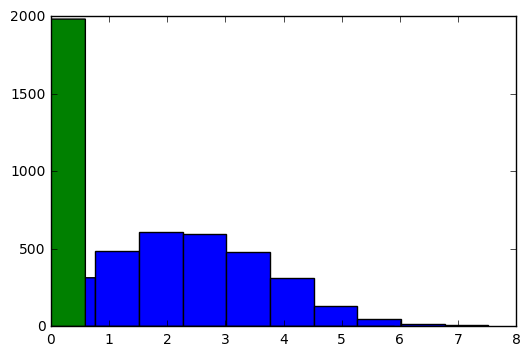

In [48]:
s1=120
plt.hist(posterior.stan_fit[:,:,s1].reshape(-1))
plt.hist(fit.extract()['f_vec_psw'][:,s1])
print fcat['S250'][sgood][prior250.ID[s1]-1]

(0, 80)

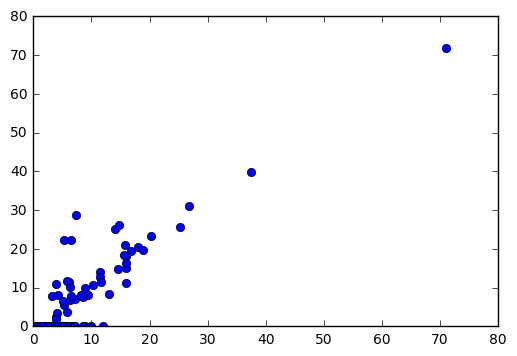

In [68]:
plt.plot(np.median(posterior.stan_fit[:,:,0:165].reshape(3000,165),axis=0),np.median(fit.extract()['f_vec_psw'],axis=0),'o')
plt.xlim(0,80)

In [64]:
np.median(fit.extract()['f_vec_psw'],axis=0).shape

(165,)

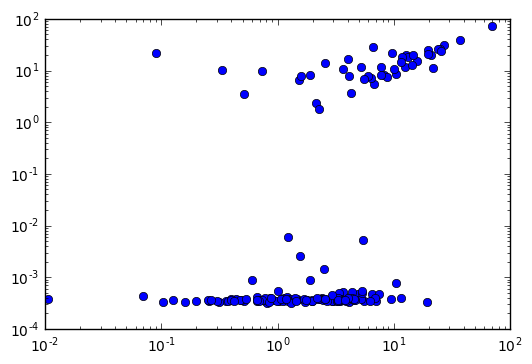

In [78]:
plt.loglog(fcat['S250'][sgood][prior250.ID[:]-1],np.median(fit.extract()['f_vec_psw'],axis=0),'o')
#plt.loglog(fcat['S250'][sgood][prior250.ID[:]-1],np.median(posterior.stan_fit[:,:,0:165].reshape(3000,165),axis=0),'o')
#plt.ylim(0,80)

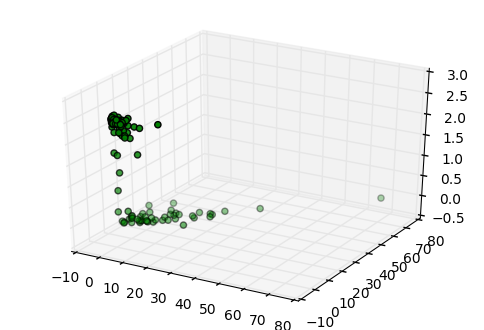

In [79]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fcat['S250'][sgood][prior250.ID[:]-1],np.median(fit.extract()['f_vec_psw'],axis=0),np.median(fit.extract()['z'],axis=0), c='g', marker='o')

In [111]:
from xidplus import posterior_maps as postmaps

hdulist_250=postmaps.make_fits_image(prior250,prior250.sim)
hdulist_350=postmaps.make_fits_image(prior350,prior350.sim)
hdulist_500=postmaps.make_fits_image(prior500,prior500.sim)

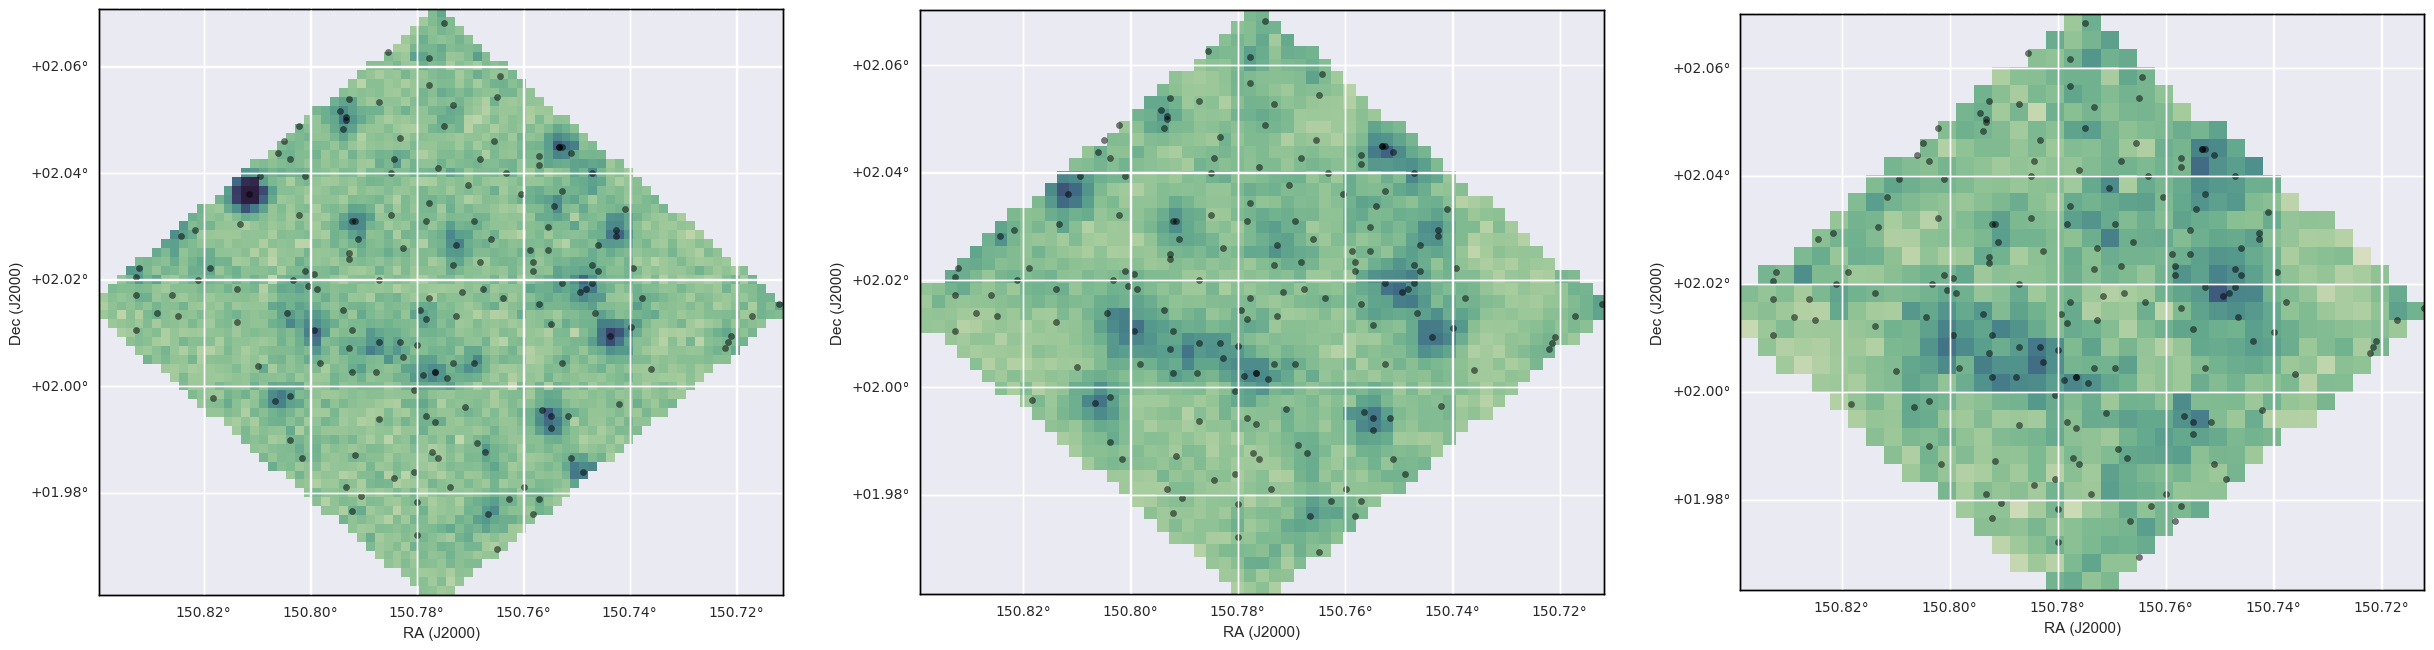

In [112]:
import aplpy
fig = plt.figure(figsize=(30,10))
real_250 = aplpy.FITSFigure(hdulist_250[1],figure=fig,subplot=(1,3,1))
real_250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
real_250.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)
real_250.tick_labels.set_xformat('dd.dd')
real_250.tick_labels.set_yformat('dd.dd')

real_350 = aplpy.FITSFigure(hdulist_350[1],figure=fig,subplot=(1,3,2))
real_350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
real_350.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)
real_350.tick_labels.set_xformat('dd.dd')
real_350.tick_labels.set_yformat('dd.dd')
real_500 = aplpy.FITSFigure(hdulist_500[1],figure=fig,subplot=(1,3,3))
real_500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
real_500.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)
real_500.tick_labels.set_xformat('dd.dd')
real_500.tick_labels.set_yformat('dd.dd')


In [104]:
mod_map=np.full((hdulist_250[1].data.shape[1],hdulist_250[1].data.shape[0],2000),np.nan)
mod_map_array=np.empty((prior250.snpix,2000))
f_vec_psw=fit.extract()['f_vec_psw']
bkg_psw=fit.extract()['bkg_psw']
sigma_conf_psw=fit.extract()['sigma_conf_psw']
for i in range(0,2000):
    mod_map_array[:,i]= postmaps.ymod_map(prior250,f_vec_psw[i,:]).reshape(-1)+bkg_psw[i]+np.random.normal(scale=np.sqrt(prior250.snim**2+sigma_conf_psw[i]**2))         
    mod_map[prior250.sx_pix-np.min(prior250.sx_pix)-1,prior250.sy_pix-np.min(prior250.sy_pix)-1,i]=mod_map_array[:,i]

In [105]:
mod_map_350=np.full((hdulist_350[1].data.shape[1],hdulist_350[1].data.shape[0],2000),np.nan)
mod_map_array_350=np.empty((prior350.snpix,2000))
f_vec_pmw=fit.extract()['f_vec_pmw']
bkg_pmw=fit.extract()['bkg_pmw']
sigma_conf_pmw=fit.extract()['sigma_conf_pmw']
for i in range(0,2000):
    mod_map_array_350[:,i]= postmaps.ymod_map(prior350,f_vec_pmw[i,:]).reshape(-1)+bkg_pmw[i]+np.random.normal(scale=np.sqrt(prior350.snim**2+sigma_conf_pmw[i]**2))         
    mod_map_350[prior350.sx_pix-np.min(prior350.sx_pix)-1,prior350.sy_pix-np.min(prior350.sy_pix)-1,i]=mod_map_array_350[:,i]

In [106]:
mod_map_500=np.full((hdulist_500[1].data.shape[1],hdulist_500[1].data.shape[0],2000),np.nan)
mod_map_array_500=np.empty((prior500.snpix,2000))
f_vec_plw=fit.extract()['f_vec_plw']
bkg_plw=fit.extract()['bkg_plw']
sigma_conf_plw=fit.extract()['sigma_conf_plw']
for i in range(0,2000):
    mod_map_array_500[:,i]= postmaps.ymod_map(prior500,f_vec_plw[i,:]).reshape(-1)+bkg_plw[i]+np.random.normal(scale=np.sqrt(prior500.snim**2+sigma_conf_plw[i]**2))         
    mod_map_500[prior500.sx_pix-np.min(prior500.sx_pix)-1,prior500.sy_pix-np.min(prior500.sy_pix)-1,i]=mod_map_array_500[:,i]

In [107]:
from tempfile import NamedTemporaryFile
VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)
from matplotlib import animation
from IPython.display import HTML


def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [110]:
import aplpy
#Set some color info
import seaborn as sns
cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True)
vmin=-1.7E1
vmax=4.446e+01
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(30,10))
res250=aplpy.FITSFigure(hdulist_250[1],figure=fig,subplot=(1,3,1))
res250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res250.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)

res350=aplpy.FITSFigure(hdulist_350[1],figure=fig,subplot=(1,3,2))
res350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res350.show_markers(prior350.sra, prior350.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)

res500=aplpy.FITSFigure(hdulist_500[1],figure=fig,subplot=(1,3,3))
res500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res500.show_markers(prior500.sra, prior500.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)

# animation function.  This is called sequentially
def animate(i):
    res250._data=mod_map[:,:,i].T
    res350._data=mod_map_350[:,:,i].T
    res500._data=mod_map_500[:,:,i].T

    res250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
    res350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
    res500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)


    return [res250,res350,res500]
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,
                               frames=100, interval=1000)

#anim.save('post_animation.mp4', fps=20, extra_args=['-vcodec', 'libx264'])

# call our new function to display the animation
display_animation(anim)

In [113]:
import scipy.stats as st

pval_250=np.empty_like(prior250.sim)
for i in range(0,prior250.snpix):
    ind=mod_map_array[i,:]<prior250.sim[i]
    pval_250[i]=st.norm.ppf(sum(ind)/np.float(mod_map_array.shape[1]))
pval_250[np.isposinf(pval_250)]=6
    
pval_350=np.empty_like(prior350.sim)
for i in range(0,prior350.snpix):
    ind=mod_map_array_350[i,:]<prior350.sim[i]
    pval_350[i]=st.norm.ppf(sum(ind)/np.float(mod_map_array_350.shape[1]))
pval_350[np.isposinf(pval_350)]=6
    
pval_500=np.empty_like(prior500.sim)
for i in range(0,prior500.snpix):
    ind=mod_map_array_500[i,:]<prior500.sim[i]
    pval_500[i]=st.norm.ppf(sum(ind)/np.float(mod_map_array_500.shape[1]))
pval_500[np.isposinf(pval_500)]=6

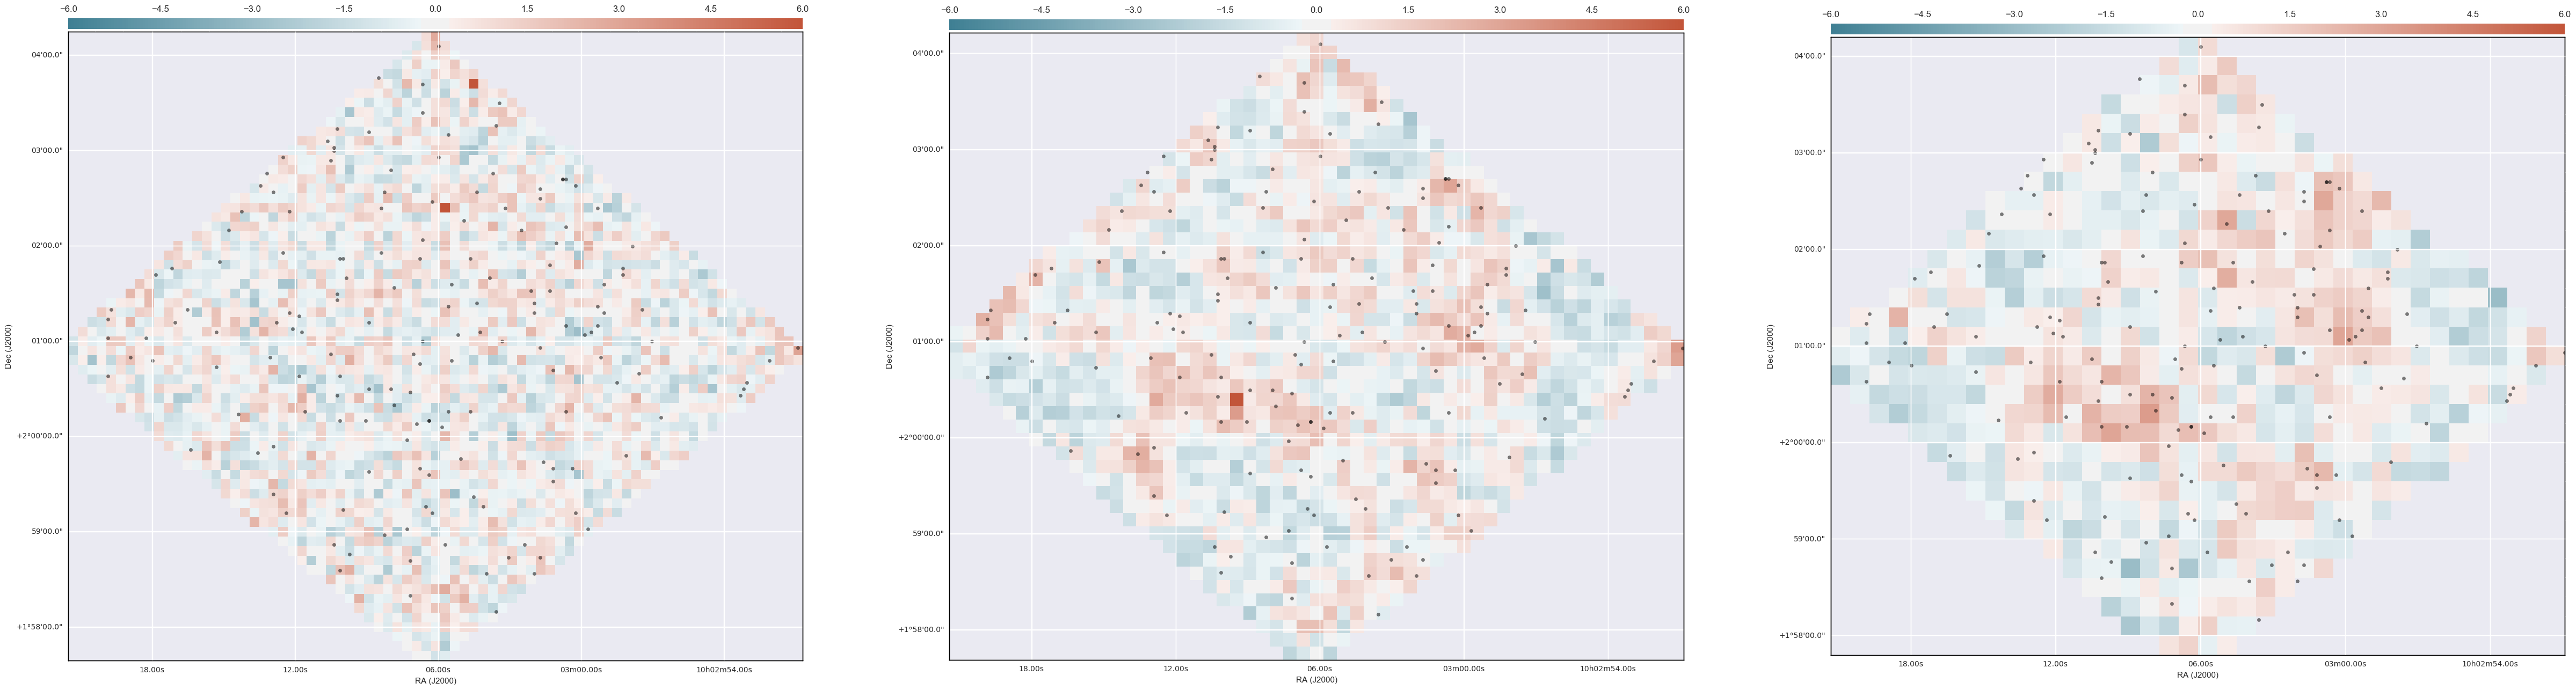

In [114]:
vmin=-6
vmax=6
cmap=sns.diverging_palette(220, 20,as_cmap=True)

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(60,20))
res250=aplpy.FITSFigure(hdulist_250[1],figure=fig,subplot=(1,3,1))
res250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res250.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)


res350=aplpy.FITSFigure(hdulist_350[1],figure=fig,subplot=(1,3,2))
res350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res350.show_markers(prior350.sra, prior350.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)

res500=aplpy.FITSFigure(hdulist_500[1],figure=fig,subplot=(1,3,3))
res500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res500.show_markers(prior500.sra, prior500.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)


res250._data[prior250.sy_pix-np.min(prior250.sy_pix)-1,prior250.sx_pix-np.min(prior250.sx_pix)-1]=pval_250
res350._data[prior350.sy_pix-np.min(prior350.sy_pix)-1,prior350.sx_pix-np.min(prior350.sx_pix)-1]=pval_350
res500._data[prior500.sy_pix-np.min(prior500.sy_pix)-1,prior500.sx_pix-np.min(prior500.sx_pix)-1]=pval_500



res250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res250.add_colorbar()
res250.colorbar.set_location('top')
res350.add_colorbar()
res350.colorbar.set_location('top')
res500.add_colorbar()
res500.colorbar.set_location('top')

(array([   6.,   23.,   86.,  237.,  464.,  557.,  403.,  175.,   39.,   10.]),
 array([ 0.90954326,  1.00206914,  1.09459502,  1.1871209 ,  1.27964678,
         1.37217266,  1.46469854,  1.55722442,  1.6497503 ,  1.74227618,
         1.83480206]),
 <a list of 10 Patch objects>)

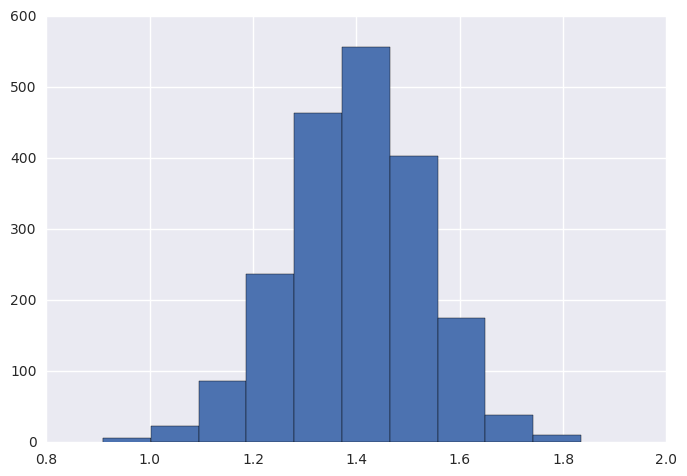

In [122]:
plt.hist(fit.extract()['sigma_conf_psw'])

In [121]:
fcat

FITS_rec([ ('            7221000005', '          250660000005', 0.1845569, 0.84729517, 1.0032376, 0.66644281, 0.30983004, 21.085098, 19.919941, 19.37451, 19.144587, 18.966915, 2.5228143588737888, 0.0, 1.1236735e+11, 84150792.0, 1.0209094e+09, 149.96883136755835, 0.10263255, 0.1009177),
       ('            7354000005', '          252230000005', 0.87909788, 2.2012999, 1.8046558, 0.99706095, 0.40617996, 20.363829, 19.324715, 18.885324, 18.697971, 18.550644, 1.0929658736848267, 0.0, 1.8167883e+11, 1.8851245e+08, 1.1518815e+09, 149.99619909196588, 0.092121005, 0.091244459),
       ('            4026000013', '          210160000013', 0.011213618, 0.041117676, 0.040524844, 0.024101084, 0.010268148, 25.039007, 23.162533, 21.708242, 21.17411, 20.850029, 2.1069606217354706, 0.0, 2.8467249e+11, 2001689.4, 6.0995297e+09, 149.13729710694184, 0.3762818, 0.3765316),
       ...,
       ('        99000241000242', '      9900063970000358', 0.0034706311, 0.22080655, 1.2660868, 1.8510325, 1.5193497, 37.5

# Why are the fluxes too low?

In [123]:


fcat['S250'][sgood][prior250.ID[:]-1]-np.median(fit.extract()['f_vec_psw'],axis=0)


array([  6.48617421e+00,   1.76439205e+00,   4.15283336e+00,
         1.31392955e+00,   1.98725525e+00,   1.49319910e+00,
        -2.35679975e-01,   2.43003723e+00,  -7.66357139e+00,
        -3.74559853e+00,   3.83328345e+00,   1.98976478e+00,
         3.25116180e+00,   3.44995628e+00,  -5.37435751e+00,
        -7.59669420e-01,   6.66722915e-01,   5.12239232e-01,
         2.10084759e+00,   2.36233760e+00,   2.97880883e+00,
         3.00977612e+00,  -4.88431490e+00,  -6.68692879e+00,
        -5.11044715e+00,  -1.25158805e+01,   1.07258841e+00,
         9.80328079e-01,   1.80458417e+00,   7.84110729e-01,
         3.01859946e+00,   3.85327072e+00,   3.57761141e-01,
        -5.38143938e-01,  -1.84911640e+00,   5.51695841e+00,
         2.93408502e+00,   3.25833175e+00,   3.70264301e+00,
         3.68762033e+00,   4.86012409e-01,   4.42425560e-01,
        -7.15604392e+00,  -2.86994239e+00,   1.13966469e+00,
         7.50338062e+00,   6.93354571e-02,   1.26434828e-01,
         1.03671640e-01,

In [128]:
pval_250_src=np.empty((prior250.nsrc))
for i in range(0,prior250.nsrc):
    ind=f_vec_psw[:,i]<fcat['S250'][sgood][prior250.ID[i]-1]
    pval_250_src[i]=sum(ind)/np.float(f_vec_psw.shape[0])


In [133]:
pval_350_src=np.empty((prior350.nsrc))
for i in range(0,prior350.nsrc):
    ind=f_vec_pmw[:,i]<fcat['S350'][sgood][prior350.ID[i]-1]
    pval_350_src[i]=sum(ind)/np.float(f_vec_pmw.shape[0])

(array([ 5.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  3.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  2.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  4.,
         0.,  0.,  2.,  0.,  1.,  2.,  2.,  8.]),
 array([ 0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,
         0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,
         0.18,  0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,
         0.27,  0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,
         0.36,  0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,
         0.45,  0.46,  0.47,  0.48,  0.49,  0.5 ,  0.51,  0.52,  0.53,
         0.54

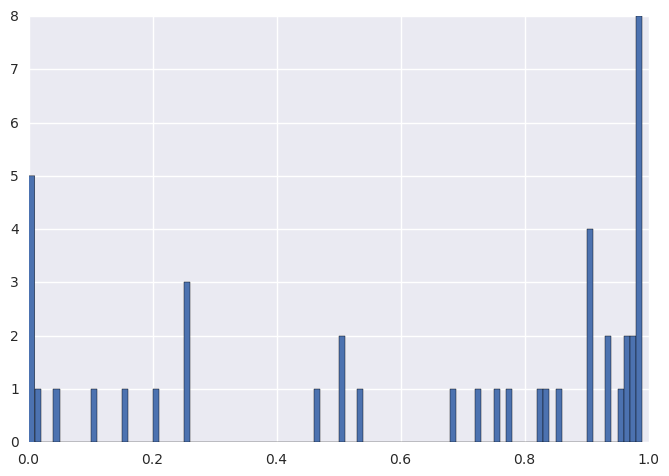

In [134]:
plt.hist(pval_350_src, bins=np.arange(0,1,0.01))

In [136]:
ind=pval_350_src >0.8

(0, 2)

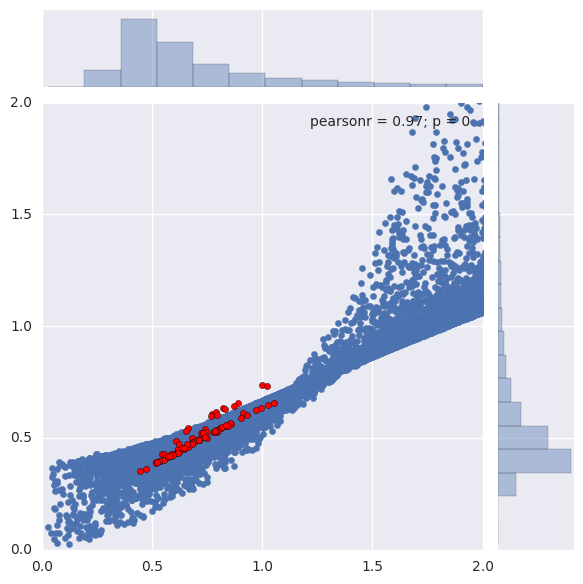

In [158]:
i=pval_250_src >0.99
g=sns.jointplot(x=f_vec_pmw[:,i]/f_vec_psw[:,i]-,y=f_vec_plw[:,i]/f_vec_pmw[:,i])
g.ax_joint.scatter(fcat['S350'][sgood][prior350.ID[i]-1]/fcat['S250'][sgood][prior350.ID[i]-1],fcat['S500'][sgood][prior350.ID[i]-1]/fcat['S350'][sgood][prior350.ID[i]-1], c='r')
g.ax_joint.set_xlim(0,2)
g.ax_joint.set_ylim(0,2)

The catalogue is close to the prior for colours, so that is not the problem.

# Is Flux distribution the problem?

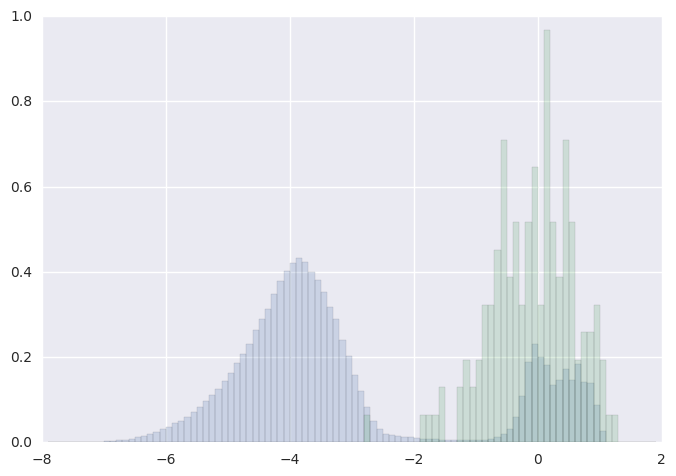

In [169]:
i=pval_250_src >0.0

x=plt.hist(np.log10(f_vec_plw[:,i].reshape(-1)), bins=np.arange(-8,2,0.1), alpha=0.2, normed=True)
y=plt.hist(np.log10(fcat['S500'][sgood][prior350.ID[i]-1]),bins=np.arange(-8,2,0.1), alpha=0.2,normed=True)

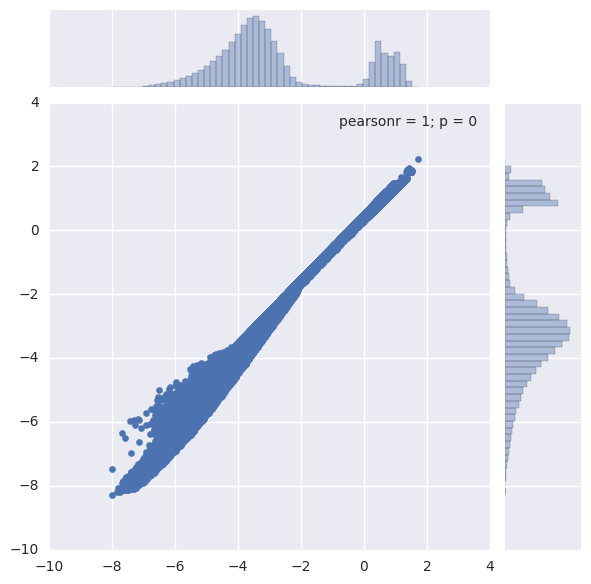

In [171]:

g=sns.jointplot(x=np.log10(f_vec_pmw[:,i].reshape(-1)),y=np.log10(f_vec_psw[:,i].reshape(-1)))

OK, I think because there are obvious sources in the 250 map, it knows the background better, therefore forces sources which are not constrained, to have a posterior flux of around $10^{-3}\mathrm{mJy}$. For the 350 and 500 maps, there are no obvious sources so background can be higher, hence fluxes for those sources not constrained can be lower.

### Why is it worse than vanilla XID+?
Well this is to do with the prior flux distribution. Previously, it was uniform between 0 and 1000. Now its far more complicated as its a function of the blackbody parameters and redshift. But in summary, the effect is prior is far lower (average of $10^{-5}$)

### How Do I Fix?
What parameter/s are causing it to be lower? Temperature, redshift and Nbb (slightly)

* Temperature is too low? Not really..
* redshift too high? well maybe.. this can be fixed by having redshift for each object
* Nbb to low and too high? Well it doesn't really correlate with L_dust